Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 58.2     |
|    ep_rew_mean      | 86       |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 8344     |
|    time_elapsed     | 0        |
|    total_timesteps  | 233      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 59.1     |
|    ep_rew_mean      | 87.1     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 8396     |
|    time_elapsed     | 0        |
|    total_timesteps  | 473      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 58.5     |
|    ep_rew_mean      | 87.3  

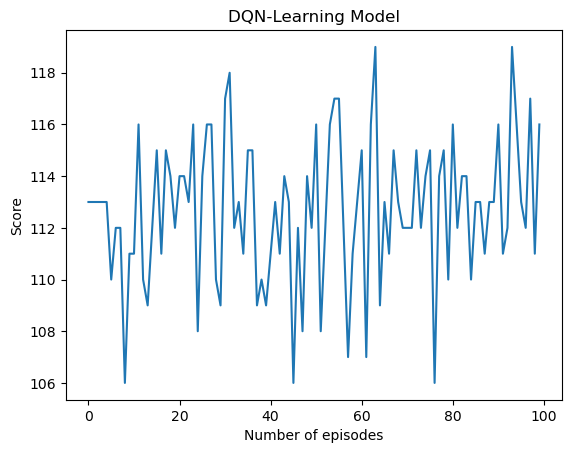

In [68]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

grid_size_x = 8
grid_size_y = 8
max_containers = grid_size_x * grid_size_y
container_priorties=[1,2]
num_priorities = len(container_priorties)

class BasicEnv(gym.Env):
    def __init__(self):
        self.action_space = gym.spaces.Discrete(grid_size_x)
        self.observation_space = gym.spaces.Box(low=0, high=num_priorities + 1, shape=( grid_size_y, grid_size_x + 1), dtype=np.int8)
        self.reset()
    def set_incoming_container_prio(self, container_prio):
        self.state [0][grid_size_x] = container_prio
    
    def get_incoming_container(self):
        return self.state [0][grid_size_x]
        
    def step(self, action):
        self.step_count += 1
        x = action
        fits = False
        
        for y in range (grid_size_y):
            if self.state [y][x] == 0:
                self.state [y][x] = self.get_incoming_container()
                fits = True
                reward = 2
                container_priority = random.choice(container_priorties)
                self.set_incoming_container_prio(container_priority)
                self.input_containers.append(container_priority)
                if ( y > 0 ):
                    if self.get_incoming_container() < self.state[ y -1 ][ x ]:
                        reward -= 1
                break
  
        if fits == False:
            reward = -2
            self.failed_attempts += 1

        done = self.step_count == max_containers or self.failed_attempts == 5
        info = {}
        return self.state, reward, done, info
    def reset(self):
        self.state = np.zeros( ( grid_size_y, grid_size_x + 1 ) )
        self.step_count = 0
        container_priority = random.choice(container_priorties)
        self.set_incoming_container_prio(container_priority)
        self.failed_attempts = 0
        self.input_containers = [container_priority]
        return self.state
    def render(self, action, reward):
        print("*******************************")
        print("action: " + str(action))
        print("reward: " + str(reward))
        print("step_count: " + str(self.step_count))
        print("incoming_container: " + str(int(self.get_incoming_container())))
        print("all incoming containers:")
        print(*self.input_containers, sep = ", ")
        for y in range(grid_size_y):
            for x in range(grid_size_x):
                print(str(int(self.state[grid_size_y-1-y][x])),end=" ")
            print("")
        
def episode(env, model):
    observation = env.reset()
    env.render(-1, 0)
    total_reward = 0
    while True:
        if ( model == None ):
            action = env.action_space.sample()
        else:
            action, _states = model.predict(observation)
        observation, reward, done, info = env.step(action)
        total_reward += reward
        env.render(action, reward)
        if done:
            print("Episode finished after {} stepcounts".format(env.step_count))
            break
    
    env.close()
    return total_reward


env = BasicEnv()

# Instantiate the agent
model = DQN('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=int(800000))

total_rewards = []   
x_axis = []
for i in range (100):    
    total_reward = episode(env, model)
    total_rewards.append (total_reward)
    x_axis.append (i)
plt.plot(x_axis,total_rewards)
plt.title('DQN-Learning Model')
plt.xlabel('Number of episodes')
plt.ylabel('Score')
plt.show()
